In [129]:
import os
import sys
sys.path.append('../../kl_tools/')
import numpy as np
from astropy.units import Unit
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim as gs
import galsim.roman as roman
from galsim.angle import Angle, radians
from astropy.visualization import ZScaleInterval, ImageNormalize

import basis
import cube
import intensity
import likelihood
import mcmc
import parameters
from parameters import Pars
import priors
import utils
import velocity
from DataSimulator import DataSimulator
from likelihood import LogLikelihood_Roman

# new modules
from spectrum import Spectrum
#from MockObs import Mock
#%matplotlib notebook
%matplotlib inline

In [187]:
R = 461*20
z = 1
offset = -656.461*(1+z)*R/500
print(offset)
#wave_range = [656.3*(1+z)*(1-200/3e5), 656.3*(1+z)*(1+200/3e5)]

pars_total = {
    # priors of sampled parameters
    'priors':{
        'g1': priors.GaussPrior(0., 0.1),
        'g2': priors.GaussPrior(0., 0.1),
        'theta_int': priors.UniformPrior(-np.pi/2., np.pi/2.),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.GaussPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10),
        'rscale': priors.UniformPrior(0, 1),
    },
    # dimension parameters for model cube
    # Note that the dimensions and scales in this parameter are irrelevant
    # to the pixel scale and number of pixels in the observed image. The 
    # model cube object is by design independent of the configurations of
    # observations. A parametric surface brightness profile is drawn on 
    # this meta-grid, then observed data will be interpolated from that. 
    'model_dimension':{
        'Nx':32,
        'Ny':32,
        'scale':0.11,# arcsec
        'lambda_range': [1310., 1315.],
        'lambda_res': 0.1,# nm
        'lambda_unit': 'nm'
    },
    # intensity profile, or surface brightness model for the galaxy
    'intensity':{
        'type':'inclined_exp',
        'hlr':0.5,# arcsec
    },
    # kinematics model for the galaxy
    'velocity':{
        'model_name': 'default',
        'v_unit':Unit('km / s'),
        'r_unit':Unit('arcsec'),
    },
    # SED model for the galaxy
    'sed':{
        'template':'../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 1.0,
        'wave_range': (500, 3000), # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (400, 1.0e-25),
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines': {'Halpha': 1.0e-15, 'OII':[1e-15, 1.2e-15], 'OIII':[1e-15, 1.2e-15]},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 0.2, 'OII':[.2,.2], 'OIII':[.3,.3]},
    },
    # observation related parameters
    # Note that from the same galaxy and shear model, we can derive 
    # multiple types of data,
    # e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
    # Thus 'observations' is a list of dictionaries that specify 
    # observation-wise parameters.
    # TODO: maybe think about more flexible way to describe dispersion
    'observations': {
        'number_of_observations': 3,
        'obs_1': {# Roman WFI/GRISM observation, roll angle 1
            'inst_name':'Roman/WFI',
             'type':'slit',
            'slit_width': 0.3,
            'slit_offset': 0.0,
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 32,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'R_spec': R ,# at 1 micron
             # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
             'psf_type':'airy',
             # pass the needed params to build PSF model here
             # in case of airy, we don't need any params
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':0.,# radian
             'offset': offset,# pix
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'none','sky_level':0.65*1.2,'read_noise':8.5,'applied':False}
         },
        'obs_2': {# Roman WFI/GRISM observation, roll angle 2
            'inst_name':'Roman/WFI',
             'type':'slit',
            'slit_width': 0.3,
            'slit_offset': 0.0,
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 32,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'R_spec': R, # at 1 micron
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':np.pi/2.,# radian
             'offset': offset,#pix
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'none','sky_level':0.65*1.2,'read_noise':8.5,'applied':False}
         },
        'obs_3': {# Roman WFI/Photometry image observation, H band
            'inst_name':'Roman/WFI',
             'type':'photometry',
             'bandpass':'../../data/Bandpass/Roman/WFI_F129.dat',
             'Nx': 32,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'none','sky_level':0.65*1.2,'read_noise':8.5,'applied':False},
         },
    },
    
    'use_numba': False,
}
sp = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
sp_val = [0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5]

test_Pars = Pars(sp, pars_total)

-24210.28168


# Testing `DataSimulator` Class

In [188]:
ds = DataSimulator(test_Pars)
%time datavectors, covmats = ds.evaluateSimulatedData(sp_val)

Initializing DataSimulator...

[SlitSpecGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = none
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (32, 32)
--- Theory slice scale = 0.11
--- Observed slice dimension = (32, 32)
--- Observed slice pixel scale = 0.11
--- Dispersion angle = 0.00 deg
--- Spectral resolution at 1um = 9220.00
--- Spectrum offset = -24210.28168 pixels
--- Slit width (FWHM) = 0.3 arcsec
--- Slit offset = 0.0 arcsec

[SlitSpecGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = none
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (32, 32)
--- Theory sl

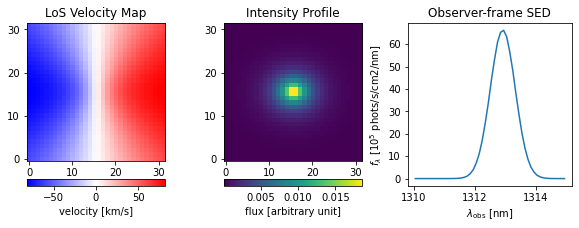

In [189]:
fig, axes = plt.subplots(1,3,figsize=(10,3))

cb1 = axes[0].imshow(ds.vmap_img*3e5, origin='lower', cmap='bwr')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.25)
plt.colorbar(cb1, cax=cax, orientation='horizontal', 
             label='velocity [km/s]')
axes[0].set_title('LoS Velocity Map')

cb2 = axes[1].imshow(ds.imap_img, origin='lower')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.25)
plt.colorbar(cb2, cax=cax, orientation='horizontal', label='flux [arbitrary unit]')
axes[1].set_title('Intensity Profile')

axes[2].plot(ds.lambda_cen, ds.sed.spectrum(ds.lambda_cen) * 1e5 )
axes[2].set(xscale='linear', yscale='linear',
            xlabel=r'$\lambda_\mathrm{obs}$ [nm]', ylabel=r'$f_\lambda$ [$10^{5}$ phots/s/cm2/nm]')
axes[2].set_title('Observer-frame SED')

plt.show()

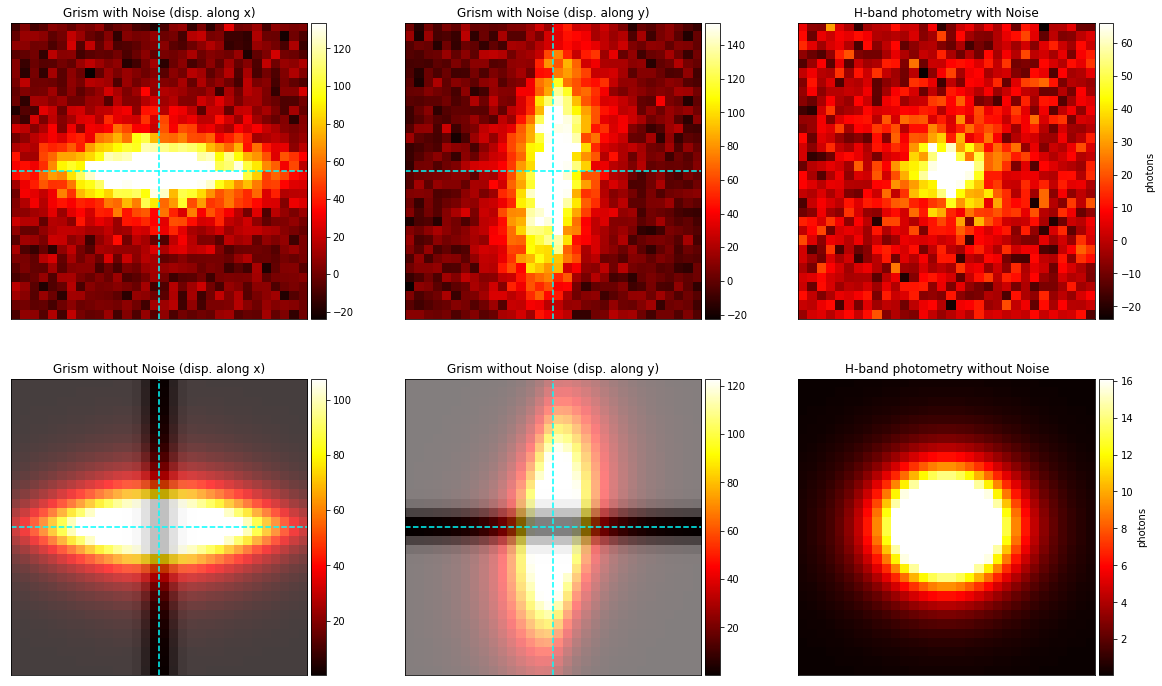

In [190]:
%matplotlib inline
fig, axes = plt.subplots(2,3, figsize=(20,12))
cmap = 'hot'

ax1 = axes[0,0]
_d = datavectors[0]+covmats[0]
cb1 = ax1.imshow(#np.arcsinh(_d),
                _d,
                 origin='lower', cmap=cmap,
                 norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
xmid = np.mean(ax1.get_xlim())
ymid = np.mean(ax1.get_ylim())
ax1.axvline(xmid, color='cyan', ls='--')
ax1.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax1.set_title("Grism with Noise (disp. along x)")
plt.colorbar(cb1, cax=cax)#, label='photons')
ax1.set(xticks=[], yticks=[])

ax2 = axes[0,1]
_d = datavectors[1]+covmats[1]
cb2 = ax2.imshow(#np.arcsinh(_d),
                _d, 
                origin='lower', cmap=cmap,
                 norm=ImageNormalize(_d, interval=ZScaleInterval()) 
                )
xmid = np.mean(ax2.get_xlim())
ymid = np.mean(ax2.get_ylim())
ax2.axvline(xmid, color='cyan', ls='--')
ax2.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax2.set_title("Grism with Noise (disp. along y)")
plt.colorbar(cb2, cax=cax)#, label='photons')
ax2.set(xticks=[], yticks=[])

ax3 = axes[0,2]
_d = datavectors[2]+covmats[2]
cb3 = ax3.imshow(_d,
                 origin='lower', cmap=cmap, 
                norm=ImageNormalize(_d, interval=ZScaleInterval()) )
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax3.set_title("H-band photometry with Noise")
plt.colorbar(cb3, cax=cax, label='photons')
ax3.set(xticks=[], yticks=[])

ax4 = axes[1,0]
_d = datavectors[0]
cb4 = ax4.imshow(_d, origin='lower', cmap=cmap,
                norm=ImageNormalize(_d, interval=ZScaleInterval()) )
ax4.imshow(ds.data_generators[0].slit_mask, origin='lower', cmap='binary', alpha=0.25)
xmid = np.mean(ax4.get_xlim())
ymid = np.mean(ax4.get_ylim())
ax4.axvline(xmid, color='cyan', ls='--')
ax4.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax4.set_title("Grism without Noise (disp. along x)")
plt.colorbar(cb4, cax=cax)#, label='photons')
ax4.set(xticks=[], yticks=[])

ax5 = axes[1,1]
_d = datavectors[1]
cb5 = ax5.imshow(_d, origin='lower', cmap=cmap,
                norm=ImageNormalize(_d, interval=ZScaleInterval()) )
ax5.imshow(ds.data_generators[1].slit_mask, origin='lower', cmap='binary', alpha=0.5)
xmid = np.mean(ax5.get_xlim())
ymid = np.mean(ax5.get_ylim())
ax5.axvline(xmid, color='cyan', ls='--')
ax5.axhline(ymid, color='cyan', ls='--')
divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax5.set_title("Grism without Noise (disp. along y)")
plt.colorbar(cb5, cax=cax)#, label='photons')
ax5.set(xticks=[], yticks=[])

ax6 = axes[1,2]
_d = datavectors[2]
cb6 = ax6.imshow(_d, origin='lower', cmap=cmap, 
                norm=ImageNormalize(_d, interval=ZScaleInterval()) )
divider = make_axes_locatable(ax6)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax6.set_title("H-band photometry without Noise")
plt.colorbar(cb6, cax=cax, label='photons')
ax6.set(xticks=[], yticks=[])

plt.show()


In [191]:
idx = 2
detect_lim = 3
include_noise = 1
for idx in range(3):
    data = datavectors[idx]
    noise = covmats[idx]
    noise_mean, noise_std = np.mean(noise), np.std(noise)
    print(f'noise mean = {noise_mean}, noise std = {noise_std}')
    mask = np.where(data > detect_lim*noise_std, np.ones(data.shape), np.zeros(data.shape))
    #plt.imshow(mask, origin='lower')

    S = np.sum( (data + noise * include_noise)  * mask)
    N = np.sqrt(np.sum(noise*noise*mask))
    snr = S/N
    print(f'SNR = {snr}')

noise mean = -0.3257761001586914, noise std = 10.347868919372559
SNR = 97.91283187241588
noise mean = 0.37276989221572876, noise std = 10.17867660522461
SNR = 110.6197140040931
noise mean = 0.34358733892440796, noise std = 8.9170503616333
SNR = 34.450927125991946


<IPython.core.display.Javascript object>


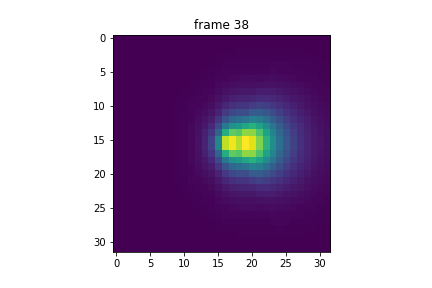

(50, 32, 32)


In [193]:
%matplotlib notebook
fig, ax = plt.subplots()
imgs = ax.imshow(np.zeros((ds.Nx, ds.Ny)))     # A tuple unpacking to unpack the only plot
vmin, vmax = np.min(ds._data), np.max(ds._data)
imgs.set_clim(vmin=vmin, vmax=vmax)
#ax.set_xlim(0, 2*np.pi)
#ax.set_ylim(-1.1, 1.1)
def animate(frame_num):
    #print(frame_num)
    mid = ds._data.shape[0] // 2
    _d = ds._data[mid-20+frame_num, :, :]
    imgs.set_data(_d)
    vmin, vmax = np.min(_d), np.max(_d)
    imgs.set_clim(vmin=vmin, vmax=vmax)
    ax.set_title('frame %d'%frame_num)
    return imgs
anim = animation.FuncAnimation(fig, animate, frames=40, 
                               interval=10, repeat=True)
plt.show()
print(ds._data.shape)

(750, 32, 32)
(9.391917206228249e-20, 4.052358343086943e-17)
(-0.5, 31.5)


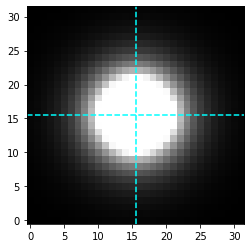

In [127]:
%matplotlib inline

interval = ZScaleInterval()
### can make a gif routine to slice through the cube!
print(ds._data.shape)
limits = interval.get_limits(ds._data[38,:,:])
print(limits)
plt.imshow(ds._data[38,:,:], origin = 'lower', cmap='gray',
           norm=ImageNormalize(ds._data[38,:,:], interval=ZScaleInterval()))
ax = plt.gca()
xmid = np.mean(ax.get_xlim())
ymid = np.mean(ax.get_ylim())
plt.axvline(xmid, color='cyan', ls='--')
plt.axhline(ymid, color='cyan', ls='--')

print(ax.get_xlim())

# Testing `LogLikelihood_Roman` Class

In [10]:
print(test_Pars.meta)
fid_sampled_pars = [0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5]
like = LogLikelihood_Roman(test_Pars, fid_pars=fid_sampled_pars)

{'priors': {'g1': <priors.GaussPrior object at 0x148a88100>, 'g2': <priors.GaussPrior object at 0x148a88160>, 'theta_int': <priors.UniformPrior object at 0x148a881f0>, 'sini': <priors.UniformPrior object at 0x148a88280>, 'v0': <priors.GaussPrior object at 0x148a882b0>, 'vcirc': <priors.GaussPrior object at 0x148a882e0>, 'rscale': <priors.UniformPrior object at 0x148a88310>}, 'model_dimension': {'Nx': 32, 'Ny': 32, 'scale': 0.11, 'lambda_range': [1275.0, 1350.0], 'lambda_res': 1, 'lambda_unit': 'nm'}, 'intensity': {'type': 'inclined_exp', 'hlr': 0.5}, 'velocity': {'model_name': 'default', 'v_unit': Unit("km / s"), 'r_unit': Unit("arcsec")}, 'sed': {'template': '../../data/Simulation/GSB2.spec', 'wave_type': 'Ang', 'flux_type': 'flambda', 'z': 1.0, 'wave_range': (500, 3000), 'obs_cont_norm': (400, 1e-15), 'lines': {'Halpha': 5e-15, 'OII': [1e-15, 1.2e-15], 'OIII': [1e-15, 1.2e-15]}, 'line_sigma_int': {'Halpha': 1, 'OII': [2, 2], 'OIII': [3, 3]}}, 'observations': {'number_of_observations'

In [11]:
%time print("log-posterior = {}".format(\
    like([0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5])\
            ))

log-posterior = 0.0
CPU times: user 213 ms, sys: 6.21 ms, total: 219 ms
Wall time: 224 ms


# Try `yaml` parameter file

In [12]:
pars_file = """

sampled_pars:
    g1:
        fid: 0.0
        mean: 0.0
        std: 0.1
        order: 1
    g2:
        fid: 0.0
        mean: 0.0
        std: 0.1
        order: 2
    theta_int:
        fid: 0.0
        min: -1.5708
        max:  1.5708
        order: 3
    sini:
        fid: 0.5
        min: 0.0
        max: 1.0
        order: 4
    v0:
        fid: 0.0
        mean: 0.0
        std:  20.0
        order: 5
    vcirc:
        fid: 200.0
        mean: 200.0
        std: 10.0
        order: 6
    rscale:
        fid: 0.5
        min: 0.0
        max: 10.0
        order: 7

# dimension parameters for model cube
# Note that the dimensions and scales in this parameter are irrelevant
# to the pixel scale and number of pixels in the observed image. The 
# model cube object is by design independent of the configurations of
# observations. A parametric surface brightness profile is drawn on 
# this meta-grid, then observed data will be interpolated from that. 

model_dimension:
    Nx: 64
    Ny: 64
    scale: 0.1 # arcsec
    lambda_range: [1275., 1350.]
    lambda_res: 1. # nm
    lambda_unit: nm

# intensity profile, or surface brightness model for the galaxy

intensity:
    type: inclined_exp
    hlr: 0.5 # arcsec

# kinematics model for the galaxy

velocity:
    model_name: default
    v_unit: km / s
    r_unit: arcsec

# SED model for the galaxy

sed:
    template: ../../data/Simulation/GSB2.spec
    wave_type: Ang
    flux_type: flambda
    z: 1.0
    wave_range: [500., 3000.] # nm
    # obs-frame continuum normalization (nm, erg/s/cm2/nm)
    obs_cont_norm: [400, 1.0e-17]
    # a dict of line names and obs-frame flux values (erg/s/cm2)
    lines:
        Halpha: 1.0e-15
        OII: [1.0e-15, 1.2e-15]
        OIII: [1.0e-15, 1.2e-15]
    # intrinsic linewidth in nm
    line_sigma_int:
        Halpha: 4.0
        OII: [2.0, 2.0]
        OIII: [3.0, 3.0]

# observation related parameters
# Note that from the same galaxy and shear model, we can derive 
# multiple types of data,
# e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
# Thus 'observations' is a list of dictionaries that specify 
# observation-wise parameters.
# TODO: maybe think about more flexible way to describe dispersion
observations:
    number_of_observations: 3
    obs_3:
        # Roman WFI/GRISM observation, roll angle 1
        inst_name: Roman/WFI
        type: grism
        bandpass: ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
        Nx: 64
        Ny: 64
        pixel_scale: 0.11 # arcsec
        R_spec: 461.0 # at 1 micron
        # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
        psf_type: airy
        # pass the needed params to build PSF model here
        # in case of airy, we don't need any params
        psf_kwargs:
            fwhm: 0.13 # arcsec
        disp_ang: 0.0 # radian
        offset: -1210 # pix
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5
     
    obs_2: # Roman WFI/GRISM observation, roll angle 2
        inst_name: Roman/WFI
        type: grism
        bandpass: ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
        Nx: 64              # number of pixels
        Ny: 64
        pixel_scale: 0.11      # arcsec
        R_spec: 461            # at 1 micron
        psf_type: airy
        psf_kwargs: 
            fwhm: 0.13     # arcsec
        disp_ang: 1.5708  # radian
        offset: -1210 #pix
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5

    obs_1: # Roman WFI/Photometry image observation, H band
        inst_name: Roman/WFI
        type: photometry
        bandpass: ../../data/Bandpass/Roman/WFI_F129.dat
        Nx: 32 # number of pixels
        Ny: 32 
        pixel_scale: 0.11 # arcsec
        psf_type: airy
        psf_kwargs:
            fwhm: 0.13 # arcsec
        diameter: 240 # cm
        exp_time: 300. # seconds
        gain: 1.
        noise:
            type: ccd
            sky_level: 0.78
            read_noise: 8.5

use_numba: False
"""

In [13]:
import yaml
print(yaml.dump(yaml.load(pars_file)))

intensity:
  hlr: 0.5
  type: inclined_exp
model_dimension:
  Nx: 64
  Ny: 64
  lambda_range:
  - 1275.0
  - 1350.0
  lambda_res: 1.0
  lambda_unit: nm
  scale: 0.1
observations:
  number_of_observations: 3
  obs_1:
    Nx: 32
    Ny: 32
    bandpass: ../../data/Bandpass/Roman/WFI_F129.dat
    diameter: 240
    exp_time: 300.0
    gain: 1.0
    inst_name: Roman/WFI
    noise:
      read_noise: 8.5
      sky_level: 0.78
      type: ccd
    pixel_scale: 0.11
    psf_kwargs:
      fwhm: 0.13
    psf_type: airy
    type: photometry
  obs_2:
    Nx: 64
    Ny: 64
    R_spec: 461
    bandpass: ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
    diameter: 240
    disp_ang: 1.5708
    exp_time: 300.0
    gain: 1.0
    inst_name: Roman/WFI
    noise:
      read_noise: 8.5
      sky_level: 0.78
      type: ccd
    offset: -1210
    pixel_scale: 0.11
    psf_kwargs:
      fwhm: 0.13
    psf_type: airy
    type: grism
  obs_3:
    Nx: 64
    Ny: 64
    R_spec: 461.0
    bandpass: ../../data/Bandp

/var/folders/y_/b_rv6p295ld1zh697qttx_yr0000gn/T/ipykernel_3490/3696662893.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  print(yaml.dump(yaml.load(pars_file)))


In [14]:
pars_dict = yaml.load(pars_file, Loader=yaml.FullLoader)

In [15]:
for key, val in pars_dict['sampled_pars'].items():
    print(key, val)

g1 {'fid': 0.0, 'mean': 0.0, 'std': 0.1, 'order': 1}
g2 {'fid': 0.0, 'mean': 0.0, 'std': 0.1, 'order': 2}
theta_int {'fid': 0.0, 'min': -1.5708, 'max': 1.5708, 'order': 3}
sini {'fid': 0.5, 'min': 0.0, 'max': 1.0, 'order': 4}
v0 {'fid': 0.0, 'mean': 0.0, 'std': 20.0, 'order': 5}
vcirc {'fid': 200.0, 'mean': 200.0, 'std': 10.0, 'order': 6}
rscale {'fid': 0.5, 'min': 0.0, 'max': 10.0, 'order': 7}


In [16]:
pars_from_yaml = Pars(yaml_file=pars_file)

Reading parameter settings from YAML file (<class 'str'>)
{'sampled_pars': {'g1': {'fid': 0.0, 'mean': 0.0, 'std': 0.1, 'order': 1}, 'g2': {'fid': 0.0, 'mean': 0.0, 'std': 0.1, 'order': 2}, 'theta_int': {'fid': 0.0, 'min': -1.5708, 'max': 1.5708, 'order': 3}, 'sini': {'fid': 0.5, 'min': 0.0, 'max': 1.0, 'order': 4}, 'v0': {'fid': 0.0, 'mean': 0.0, 'std': 20.0, 'order': 5}, 'vcirc': {'fid': 200.0, 'mean': 200.0, 'std': 10.0, 'order': 6}, 'rscale': {'fid': 0.5, 'min': 0.0, 'max': 10.0, 'order': 7}}, 'model_dimension': {'Nx': 64, 'Ny': 64, 'scale': 0.1, 'lambda_range': [1275.0, 1350.0], 'lambda_res': 1.0, 'lambda_unit': 'nm'}, 'intensity': {'type': 'inclined_exp', 'hlr': 0.5}, 'velocity': {'model_name': 'default', 'v_unit': 'km / s', 'r_unit': 'arcsec'}, 'sed': {'template': '../../data/Simulation/GSB2.spec', 'wave_type': 'Ang', 'flux_type': 'flambda', 'z': 1.0, 'wave_range': [500.0, 3000.0], 'obs_cont_norm': [400, 1e-17], 'lines': {'Halpha': 1e-15, 'OII': [1e-15, 1.2e-15], 'OIII': [1e-15,

In [17]:
like_from_yaml = LogLikelihood_Roman(pars_from_yaml, fid_pars=pars_from_yaml.sampled_fid)

Initializing DataSimulator...

[ImageGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_F129.dat
--- Theory slice dimension = (64, 64)
--- Theory slice scale = 0.10
--- Observed slice dimension = (32, 32)
--- Observed slice pixel scale = 0.11

[GrismGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (64, 64)
--- Theory slice scale = 0.10
--- Observed slice dimension = (64, 64)
--- Observed slice pixel scale = 0.11
--- Dispersion angle = 90.00 deg
--- Spectral resolution at 1um = 461.00
--- Grism offset = -1210 pixe

In [18]:
%time print(f'loglike at fid pars = {like_from_yaml(pars_from_yaml.sampled_fid)}')
%time print(f'loglike at others = {like_from_yaml([0.01, 0.01, 0.01, 0.5, 0.0, 200.0, 0.5])}')

loglike at fid pars = 0.0
CPU times: user 286 ms, sys: 5.92 ms, total: 292 ms
Wall time: 292 ms
loglike at others = -9150.613861132382
CPU times: user 316 ms, sys: 6.09 ms, total: 322 ms
Wall time: 329 ms


In [19]:
%time likes = [like_from_yaml([0.01, 0.01, 0.01, 0.5, 0.0, 200.0, 0.5]) for i in range(100)]

CPU times: user 27.3 s, sys: 364 ms, total: 27.7 s
Wall time: 27.7 s


In [20]:
'priors' in like_from_yaml.meta.keys()

True

In [21]:
48//2

24